In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
from matplotlib import pyplot as plt
import random
import numpy as np
import sys
from collections import deque

matplotlib.style.use('ggplot')

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_config

print(tf.__version__)
print(tf.keras.__version__)

2.0.0-alpha0
2.2.4-tf


In [3]:
class Memory:   # stored as ( s, a, r, s_, d )
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def add(self, sample, error):
        self.memory.append(sample)        

    def sample(self, n):
        n = min(n, len(self.memory))
        return random.sample(self.memory, n)

    def isFull(self):
        return len(self.memory) >= self.memory.maxlen
    
    def update(self, idx, p):
        pass


class SumTree:
    def __init__(self, capacity):
        self.write = 0
        self.capacity = capacity
        self.tree = np.zeros( 2*capacity - 1 )
        self.data = np.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    
class SumTreeMemory:   # stored as ( s, a, r, s_, d ) in SumTree
    e = 0.01
    a = 1

    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, sample, error):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [4]:
class DQNAgent:
    def __init__(self, observation_size, action_size):
        self.observation_size = observation_size
        self.action_size = action_size
        self.hidden_units = 64
        self.batch_size = 32
        
        self.gamma = 1.0
        self.epsilon = 0.1
        self.learning_rate = 0.001
        
        self.memory = Memory(10000)
            
        self.model = self._build_model()
        self.model_target = self._clone_model(self.model)
        
        self.update_target_model()

    def _build_model(self):
        model = tf.keras.Sequential([
            layers.Dense(self.hidden_units, 
                         input_shape=(self.observation_size,),
                         activation='relu', 
                         kernel_initializer='he_uniform'),
            layers.Dense(self.hidden_units, 
                         activation='relu',
                         kernel_initializer='he_uniform'),
            layers.Dense(self.action_size, 
                         activation='linear',
                         kernel_initializer='he_uniform')
        ])

        model.compile(optimizer=tf.keras.optimizers.Adam(self.learning_rate),
                      loss='mse')
        return model
    
    def _clone_model(self, model):
        config = {
            'class_name': model.__class__.__name__,
            'config': model.get_config(),
        }
        clone = model_from_config(config)
        clone.set_weights(model.get_weights())
        return clone       
        
    def _act_egreedy(self, best_action):
        action_probs = np.ones(self.action_size, dtype=float) * self.epsilon / self.action_size
        action_probs[best_action] += (1.0 - self.epsilon)
        return np.random.choice(np.arange(len(action_probs)), p=action_probs)

    def remember(self, sample):
        _, _, errors = self._get_targets([sample])
        self.memory.add(sample, errors[0])
        
    def act(self, observation, train=True):
        observation = np.reshape(observation, [1, self.observation_size]) 
        q_values = self.model.predict(observation)[0]
        action = np.argmax(q_values)
        
        if (train==True):
            # if we are training.  choose e-greedy.
            action = self._act_egreedy(action)
        
        return action
    
    def _get_targets(self, batch):
        no_state = np.zeros(self.observation_size)

        observations = np.array([ x[0] for x in batch ])
        next_observations = np.array([ (no_state if x[4] is True else x[3]) for x in batch ])

        p = self.model.predict(observations)
        p_ = self.model.predict(next_observations)
        pTarget_ = self.model_target.predict(next_observations)
        
        targets = p
        
        errors = np.zeros(len(batch))
        
        for index, sample in enumerate(batch):
            action = sample[1]
            reward = sample[2]
            done = sample[4]
            
            old_target = targets[index][action]
            
            if (done == True):
                targets[index][action] = reward
            else:
                targets[index][action] = reward + self.gamma * pTarget_[index][ np.argmax(p_[index]) ]  # double DQN
        
            errors[index] = abs(old_target - targets[index][action])

        return observations, targets, errors
        
    def replay(self):
        batch = self.memory.sample(self.batch_size)
        observations, targets, errors = self._get_targets(batch)

        #update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])

        self.model.fit(observations, targets, epochs=1, verbose=0)

    def update_target_model(self):
        self.model_target.set_weights(self.model.get_weights())        
                

def train_agent (env, agent, num_episodes, train_until):
      
    rewards = []
        
    for episodeIx in range(num_episodes):
        # reset state in the beginning of each game
        done = False
        observation = env.reset()
        episode_rewards = 0
        while not done:
            action = agent.act(observation)
            next_observation, reward, done, _ = env.step(action)
            agent.remember((observation, action, reward, next_observation, done))
            observation = next_observation
            episode_rewards += reward
            
            # train the agent with the experience of the episode
            agent.replay()
            
        agent.update_target_model()
        
        rewards.append(episode_rewards)
        
        rewards_mean = np.mean(rewards[-min(15, len(rewards)):])
        
        print("\repisode: {}/{}.  rewards was {}.  Mean is {}".format(episodeIx+1, num_episodes, episode_rewards, rewards_mean), end="")
            
        if  rewards_mean > train_until:
            break
            
    return rewards
            
def run_episode(env, agent, render=True):
    rewards = 0
    done = False
    observation = env.reset()

    while not done:
        if (render is True):
            env.render()
        action = agent.act(observation, train=False)
        observation, reward, done, _ = env.step(action)
        rewards += reward
        
    return rewards

In [5]:
env = gym.make('CartPole-v1')

observation_size = env.observation_space.shape[0]
action_size = env.action_space.n

In [6]:
agent = DQNAgent(observation_size, action_size)

In [7]:
rewards = train_agent(env, agent, 1000, 490)

episode: 177/1000.  rewards was 500.0.  Mean is 490.26666666666665

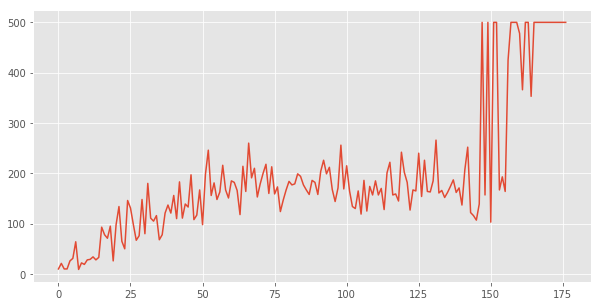

In [8]:
fig = plt.figure(figsize=(10,5))
plt.plot(rewards)
plt.show(fig)

In [9]:
agent.model.load_weights("cartpole_dqn.h5")
#agent.model.save_weights("cartpole_dqn.h5")

In [10]:
run_episode(env, agent)

500.0

In [11]:
alpha = 1
epsilon = 0.0001
errors = np.array([10, 3, 2, 1, 0])

In [12]:
priority = np.power(errors + epsilon, alpha)
priority_sum = np.sum(priority)
probabilty = np.around(priority / priority_sum,2)


In [13]:
print (priority)
print (probabilty)

[1.00001e+01 3.00010e+00 2.00010e+00 1.00010e+00 1.00000e-04]
[0.62 0.19 0.13 0.06 0.  ]
